<img style="float: center;" src="../support/images/CI_horizontal.png" width="400">

https://coleridgeinitiative.org/

## Clustering for data exploration


In [10]:
# initial libraries
# packages to get/prep data
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# packages for clustering & exploration
from sklearn.cluster import KMeans

from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz, DecisionTreeClassifier
# import graphviz as gv
import pydotplus

# set visualization scheme
sns.set_style('darkgrid')
%matplotlib notebook

## Get data

In [3]:
######## 1. Database connection #################
DB = 'datadb'
USER = 'clayton'
HOST = 'localhost'
PORT = '5432'
PW = 'clayton'

DB_CONNECTION_STRING = 'postgresql://{username}:{password}@{host}:{port}/{database}'.format(
username=USER, password=PW, host=HOST, port=PORT, database=DB)

engine = create_engine(DB_CONNECTION_STRING)

In [4]:
######## 2. functions to get data ###################
# function to get data - cbsafp = '28140' is KCMO metro area
# returns the base, Block level data
def getWAC(seg='s000', jt='jt01', years=xrange(2002,2016), cbsafp = '28140'):
    # to pull data from database
    DFs = []
    # get data
    for year in years:
        qry = """
        SELECT *, left(w_geocode, 5) countyfp, {YR} AS year 
        FROM lodes.mo_wac_{SEG}_{JT}_{YR}
        WHERE left(w_geocode, 5) 
        IN (SELECT geoid FROM tl_2016_us_county WHERE cbsafp = '{CBSA}')
        """.format(SEG=seg, JT=jt, YR=year, CBSA=cbsafp)
        # pull DataFrame of given data parameters
        df = pd.read_sql(qry, engine)
        # add to list of DataFrames
        DFs.append(df)
    # combine collected DFs into single dataframe
    df = pd.concat(DFs)
    return(df)


In [5]:
df = getWAC(years=[2004])

In [6]:
# make it easy to copy & paste desired columns into "sel_columns" list in next cell
print(', '.join(["'"+c+"'" for c in df.columns.tolist()]))

'w_geocode', 'c000', 'ca01', 'ca02', 'ca03', 'ce01', 'ce02', 'ce03', 'cns01', 'cns02', 'cns03', 'cns04', 'cns05', 'cns06', 'cns07', 'cns08', 'cns09', 'cns10', 'cns11', 'cns12', 'cns13', 'cns14', 'cns15', 'cns16', 'cns17', 'cns18', 'cns19', 'cns20', 'cr01', 'cr02', 'cr03', 'cr04', 'cr05', 'cr07', 'ct01', 'ct02', 'cd01', 'cd02', 'cd03', 'cd04', 'cs01', 'cs02', 'cfa01', 'cfa02', 'cfa03', 'cfa04', 'cfa05', 'cfs01', 'cfs02', 'cfs03', 'cfs04', 'cfs05', 'createdate', 'countyfp', 'year'


In [14]:
# select columns for this example: age & income
sel_columns = ['ca01', 'ca02', 'ca03', 'ce01', 'ce02', 'ce03']

## Clustering workflow

Everything below should work given an input DataFrame `df` for which `sel_columns` is the list of columns on which we are performing clustering analysis

Rayid's guidance:

**Step 1**: select # of clusters (fairly arbitrary choice, say 5) and do clustering. Output will be a cluster id for each row in the data

**Step 2**: describe the clusters that are produced. Two approaches:
- A. Use decision tree with the same features as in the clustering but with the cluster id as the output variable. Print the tree to understand what the clusters are
- B. Do some descriptive stats on each cluster (or cross tabs) to get an idea of what the cluster is

**Step 3**. 
- A. Ideally, decide if some clusters needs to be split or combined and then redo Step 2.
- B. Less ideally, modify number of clusters and then redo step 2 o see if they make more sense.

### Create clusters

In [15]:
# select number of clusters
k = 5

# set cluster algorithm parameters
kmeans = KMeans(n_clusters=k)

# run clustering algorithm
clusters = kmeans.fit(df[sel_columns].values)

# attach cluster labels back to DataFrame
df['cluster'] = clusters.labels_

### Explore clusters

In [16]:
# descriptive stats - what is most useful way to display this?
df.groupby('cluster')[sel_columns].agg(['mean', 'median']).T

cluster              0           1       2           3            4
ca01 mean     6.043968  251.954545   617.5   90.289855   622.166667
     median   2.000000  232.500000   617.5   73.000000   520.000000
ca02 mean    11.265040  722.924242  3807.5  187.720497  2017.083333
     median   3.000000  687.000000  3807.5  158.000000  1955.500000
ca03 mean     3.235318  170.439394   780.0   50.066253   371.250000
     median   1.000000  150.000000   780.0   42.000000   345.500000
ce01 mean     6.491647  165.878788   293.0   84.569358   219.250000
     median   2.000000  127.000000   293.0   61.000000   156.500000
ce02 mean     8.979399  517.272727   926.0  143.571429  1149.083333
     median   3.000000  465.000000   926.0  123.000000  1274.000000
ce03 mean     5.073281  462.166667  3986.0   99.935818  1642.166667
     median   1.000000  434.500000  3986.0   80.000000  1692.000000

In [19]:
df.groupby('cluster')[sel_columns].agg('median')

,ca01,ca02,ca03,ce01,ce02,ce03
cluster,,,,,,
0,2.0,3.0,1.0,2.0,3.0,1.0
1,232.5,687.0,150.0,127.0,465.0,434.5
2,617.5,3807.5,780.0,293.0,926.0,3986.0
3,73.0,158.0,42.0,61.0,123.0,80.0
4,520.0,1955.5,345.5,156.5,1274.0,1692.0


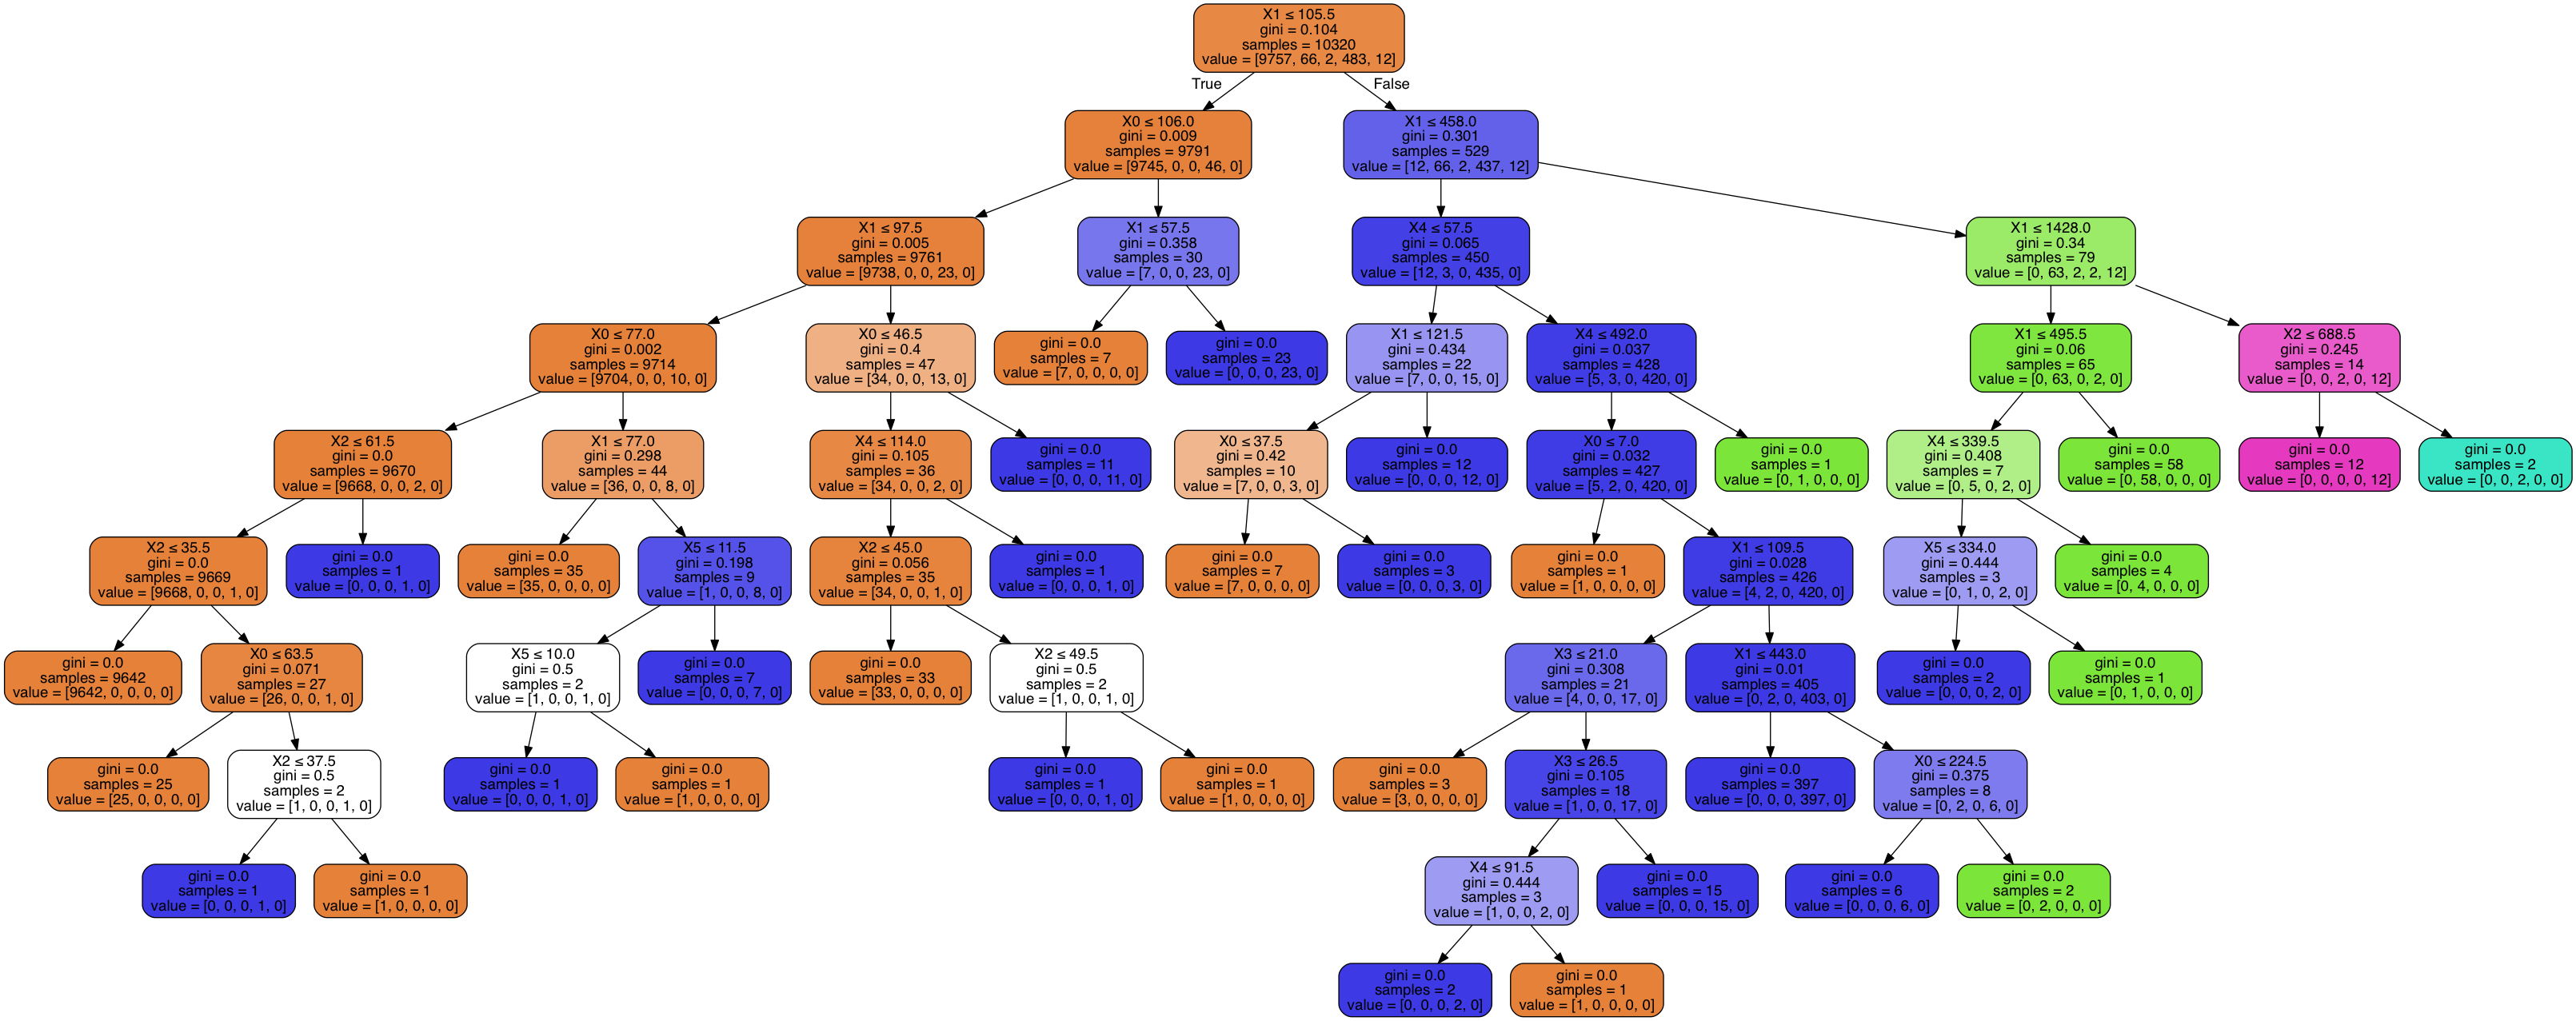

In [20]:
# explore with DecisionTreeClassifer

# create and fit tree
dtc = DecisionTreeClassifier()
dtc.fit(df[sel_columns], df['cluster'])

# visualize tree
dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())